In [1]:
import sys
print(sys.version)

3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies

import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1) 
rn.seed(3) 
import tensorflow as tf
tf.random.set_seed(2) 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model 
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers  
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [3]:
# Loading the dataset
url = './thesis_dataset/GOOGL.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-24,1350.209961,1352.010010,1344.170044,1344.430054,1344.430054,673400
2019-12-26,1346.550049,1363.199951,1345.510010,1362.469971,1362.469971,1183100
2019-12-27,1364.000000,1367.050049,1353.000000,1354.640015,1354.640015,1160600
2019-12-30,1356.810059,1357.000000,1337.839966,1339.709961,1339.709961,999700
2019-12-31,1335.790039,1340.660034,1332.130005,1339.390015,1339.390015,975700


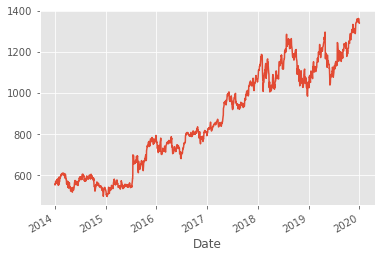

In [4]:
df['Close'].plot()

In [5]:
# Correlation matrix
df.corr()['Close']

Open         0.999074
High         0.999539
Low          0.999630
Close        1.000000
Adj Close    1.000000
Volume      -0.263872
Name: Close, dtype: float64

count    1.510000e+03
mean     1.997124e+06
std      1.121032e+06
min      5.206000e+05
25%      1.346575e+06
50%      1.679950e+06
75%      2.250775e+06
max      1.285810e+07
Name: Volume, dtype: float64


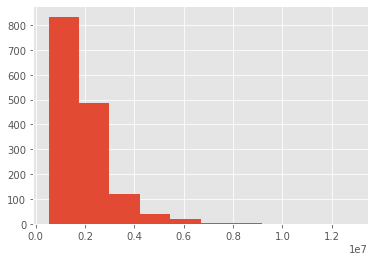

In [6]:
# Distribution of Various Features
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [7]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [8]:
#Build and train the model
def fit_model(train_X,val_X,train_Y,val_Y,timesteps,hl,lr,batch,epochs): #hl=[50,,45] 
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train_X.shape[0]):
        X_train.append(train_X[i-timesteps:i])
        Y_train.append(train_Y[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val_X.shape[0]):
        X_val.append(val_X[i-timesteps:i])
        Y_val.append(val_Y[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,activation = 'relu'))
    
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
        
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')  #lr learning rate
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [9]:
# Evaluating the model
def evaluate_model(sc,model,test_X,test_Y,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test_X.shape[0]):
        X_test.append(test_X[i-timesteps:i])
        Y_test.append(test_Y[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!  
    Y_hat = model.predict(X_test)
    Y_hat= Y_hat.reshape(1,-1)
    Y_test= Y_test.reshape(1,-1)
    Y_test_true = sc.inverse_transform(Y_test)
    Y_hat_true = sc.inverse_transform(Y_hat)
    Y_test_true = Y_test_true[0]
    Y_hat_true = Y_hat_true[0]
    mse = mean_squared_error(Y_test_true,Y_hat_true)
    rmse = sqrt(mse)
    r = r2_score(Y_test_true,Y_hat_true)
    accuracy = 1 - np.sqrt(np.mean(np.square((Y_hat_true - Y_test_true) / Y_test_true)))
    accuracy=accuracy * 100
    return mse, rmse, r, Y_test_true, Y_hat_true,accuracy
  

In [10]:

# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(16,8))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.ylabel('Close Price',fontsize=18)
    plt.xlabel('Day',fontsize=18)
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [11]:

# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.figure(figsize=(16,8))
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss',fontsize=18)
    plt.xlabel('Epochs',fontsize=18)
    plt.title('Loss Function')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [12]:
# Plotting the errors
def plot_predict_error(true,predicted):
    plt.figure(figsize=(16,8))
    error = true-predicted
    plt.plot(error,c = 'r')
    plt.ylabel('Error',fontsize=18)
    plt.xlabel('Day',fontsize=18)
    plt.title('Rrror Function')
    plt.legend(['error'],loc = 'upper right')
    plt.show()


In [13]:
# Extracting the series
Train_series_X = df
Train_series_Y = df[['Close']]

In [14]:
# Train Val Test Dataset Split
train_start = dt.date(2014,1,1)
train_end = dt.date(2018,12,31)
train_data_X = Train_series_X.loc[train_start:train_end]
train_data_Y = Train_series_Y.loc[train_start:train_end]

val_start = dt.date(2019,1,1)
val_end = dt.date(2019,12,31)
val_data_X = Train_series_X.loc[val_start:val_end]
val_data_Y = Train_series_Y.loc[val_start:val_end]
test_start = dt.date(2019,1,1)
test_end = dt.date(2019,12,31)
test_data_X = Train_series_X.loc[test_start:test_end]
test_data_Y = Train_series_Y.loc[test_start:test_end]
print(train_data_X.shape,val_data_X.shape,test_data_X.shape,train_data_Y.shape,val_data_Y.shape,test_data_Y.shape)

(1258, 6) (252, 6) (252, 6) (1258, 1) (252, 1) (252, 1)


In [15]:
scaler_X = MinMaxScaler()
train_X = scaler_X.fit_transform(train_data_X)
val_X = scaler_X.transform(val_data_X)
test_X = scaler_X.transform(test_data_X)
print(train_X.shape,val_X.shape,test_X.shape)

(1258, 6) (252, 6) (252, 6)


In [16]:
scaler_Y = MinMaxScaler()
train_Y = scaler_Y.fit_transform(train_data_Y)
val_Y = scaler_Y.transform(val_data_Y)
test_Y = scaler_Y.transform(test_data_Y)
print(train_Y.shape,val_Y.shape,test_Y.shape)

(1258, 1) (252, 1) (252, 1)


In [17]:
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = 32
num_epochs = 250

Epoch 00156: early stopping


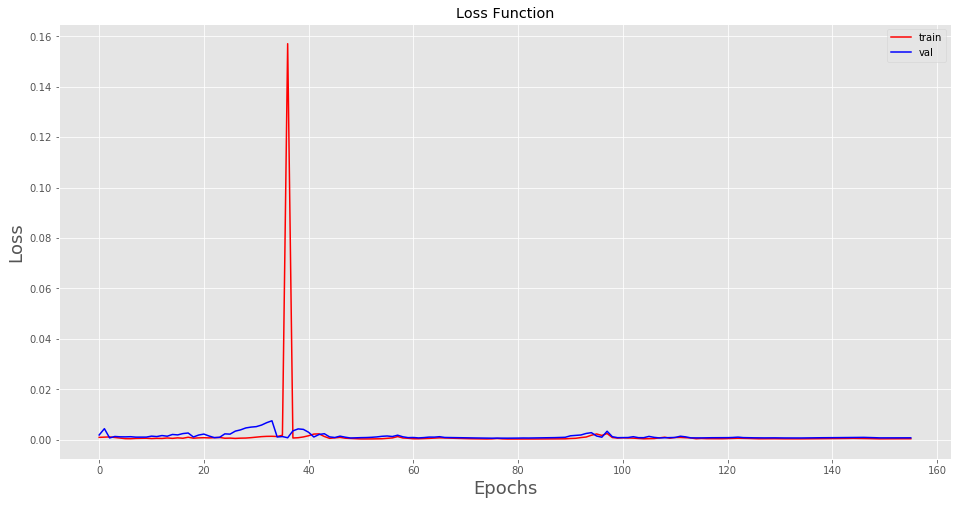

In [18]:
model,train_error,val_error = fit_model(train_X,val_X,train_Y,val_Y,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 469.3821090423803
RMSE = 21.66522810963181
R-Squared Score = 0.9166430174520706
accuracy = 98.17020391029914


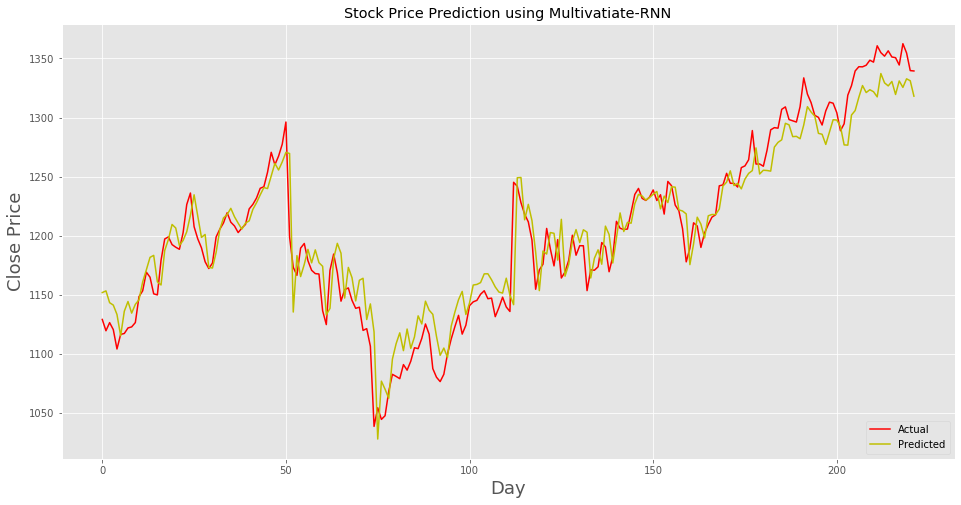

In [19]:
mse, rmse, r2_value,true,predicted,accuracy = evaluate_model(scaler_Y,model,test_X,test_Y,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print('accuracy = {}'.format(accuracy))
plot_data(true,predicted)

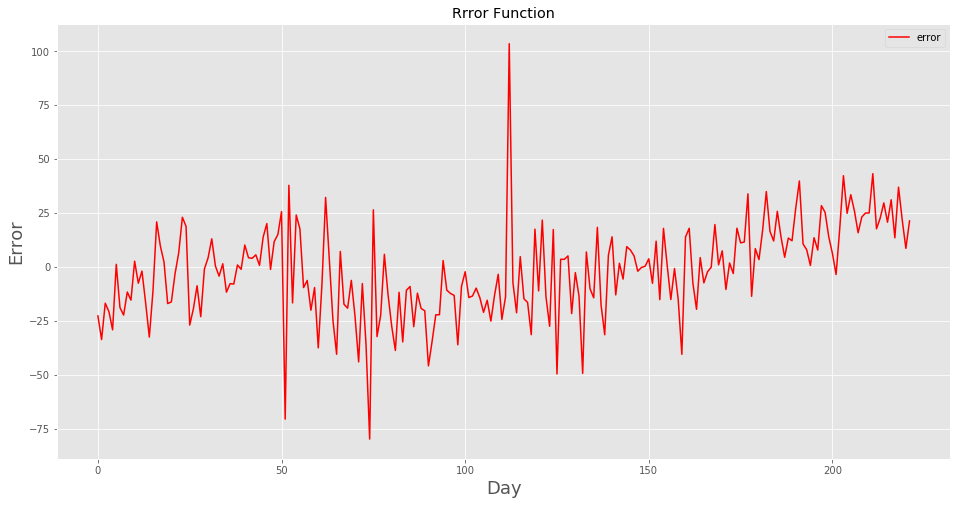

In [20]:
plot_predict_error(true,predicted)